<b>Import libraries

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                       SequentialFeatureSelector,
                                       VarianceThreshold, chi2, f_classif,
                                       mutual_info_classif)
from sklearn.metrics import (auc, classification_report, confusion_matrix,
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from diagnostics import ClassificationDiagnostics  # custom class
from minmaxscaler import mmscaler

<b>Import dataset


In [2]:
DATA_PATH = os.path.join(Path(os.getcwd()).parent, "data\\train_set.pkl")

In [3]:
with open(DATA_PATH,"rb") as f:
    df = pickle.load(f)
df

,Date,Index,daily_returns,momentum30,momentum60,momentum120,vs_quantile,vs_quantile_binary,vs_quantile_binary_freq,divergence,lag_returns,sell_signal
0,2010-06-25,4.579647,0.545185,98.852998,99.186729,99.445776,0.148886,0.0,0.083333,-0.030905,-2.193406,1
1,2010-06-28,4.580263,0.061532,99.368701,99.155543,99.465618,0.141364,0.0,0.083333,-0.031225,0.545185,1
2,2010-06-29,4.537961,-4.230111,98.279685,97.914172,98.598467,-1.823472,1.0,0.100000,-0.032261,0.061532,1
3,2010-06-30,4.523635,-1.432674,98.375237,97.596871,98.342961,-0.228739,0.0,0.100000,-0.032895,-4.230111,1
4,2010-07-01,4.522223,-0.141143,98.439591,97.601193,98.128629,0.136183,0.0,0.100000,-0.033432,-1.432674,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2896,2021-12-27,7.338830,2.007130,100.490500,101.924288,101.959527,0.445107,0.0,0.033333,0.025429,0.781389,0
2897,2021-12-28,7.334336,-0.449377,100.309045,101.708571,102.030084,0.113669,0.0,0.033333,0.024129,2.007130,0
2898,2021-12-29,7.337347,0.301111,100.382438,102.028622,101.880797,0.137352,0.0,0.033333,0.022629,-0.449377,0
2899,2021-12-30,7.330857,-0.648971,100.167129,101.782684,101.794794,0.093081,0.0,0.033333,0.020897,0.301111,0


<b> Minmax scaler

In [4]:
num_columns = ["daily_returns", "momentum30", "momentum60", "momentum120", "vs_quantile", "divergence", "lag_returns"]
df = mmscaler(df = df, columns = num_columns)
df

,daily_returns,momentum30,momentum60,momentum120,vs_quantile,divergence,lag_returns,Date,Index,vs_quantile_binary,vs_quantile_binary_freq,sell_signal
0,0.584934,0.441176,0.404351,0.350211,0.588236,0.393218,0.474406,2010-06-25,4.579647,False,0.083333,True
1,0.565414,0.492704,0.40173,0.351646,0.587818,0.391574,0.584934,2010-06-28,4.580263,False,0.083333,True
2,0.392206,0.383893,0.297372,0.288934,0.478561,0.386246,0.565414,2010-06-29,4.537961,True,0.1,True
3,0.505109,0.39344,0.270697,0.270457,0.567238,0.382988,0.392206,2010-06-30,4.523635,False,0.1,True
4,0.557234,0.39987,0.271061,0.254956,0.58753,0.380228,0.505109,2010-07-01,4.522223,False,0.1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2896,0.643938,0.60479,0.634489,0.532002,0.604708,0.682735,0.594467,2021-12-27,7.33883,False,0.033333,False
2897,0.544794,0.586659,0.616354,0.537105,0.586278,0.676053,0.643938,2021-12-28,7.334336,False,0.033333,False
2898,0.575083,0.593992,0.64326,0.526309,0.587595,0.668345,0.544794,2021-12-29,7.337347,False,0.033333,False
2899,0.536739,0.572479,0.622585,0.520089,0.585133,0.659443,0.575083,2021-12-30,7.330857,False,0.033333,False


<b> Specify model and set up cross validator

In [5]:
# Gradient Boosting Classifier

model = GradientBoostingClassifier(random_state=1)

In [8]:
# Specify dependent variable and predictors

y = df.loc[:,"sell_signal"]
X = df.loc[:, df.columns.drop(["Date","Index","sell_signal"])]

In [9]:
# Cross Validator

cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=123)

# Generate train and test sets using stratified K-fold splits, decide if number of positive classes in train/test splits is sufficient

for train_idx, test_idx in cv.split(X,y):
    # print(train_idx)
    train_X, test_X = X.loc[train_idx, :], X.loc[test_idx,:]
    train_y, test_y = y[train_idx], y[test_idx]

    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])

    print(">Train: 0=%d, 1=%d, Test: 0=%d, 1=%d" % (train_0, train_1, test_0, test_1))

>Train: 0=2231, 1=379, Test: 0=248, 1=43
>Train: 0=2232, 1=379, Test: 0=247, 1=43
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42


In [10]:
# Stratified K-Fold cross validation using F1 stat as model evaluation metric - focus on minority class
# Fit using all features

scores = cross_val_score(model, X, y, scoring = "f1", cv = cv, n_jobs = -1)
print("F1 score: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

F1 score: 0.851 (0.036)


<b> Feature Selection</b>  
Can model perform better on limited number of features?

In [11]:
# Create dictionary to store selected features

feature_selection = {}
feature_selection["Features_set"] = X.columns.tolist()

<font size = 3><u> 1. Variance treshold optimization

In [12]:
# Parameters optimization

pipe = Pipeline(
    [("selector", VarianceThreshold()),("classifier",model)]
)

parameters = {
    "selector__threshold": [0.001, 0.0025, 0.005, 0.007, 0.01, 0.02, 0.03]   
}

grid = GridSearchCV(pipe, parameters, cv = cv, scoring = "f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)
pd.DataFrame.from_dict(grid.cv_results_, orient = "columns")

{'selector__threshold': 0.005}
Pipeline(steps=[('selector', VarianceThreshold(threshold=0.005)),
                ('classifier', GradientBoostingClassifier(random_state=1))])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.412998,0.205993,0.009601,0.003076,0.001,{'selector__threshold': 0.001},0.814815,0.804878,0.878049,0.864198,0.888889,0.847059,0.857143,0.850000,0.794521,0.814815,0.841437,0.030687,2
1,1.443760,0.061668,0.009278,0.002683,0.0025,{'selector__threshold': 0.0025},0.814815,0.804878,0.878049,0.864198,0.888889,0.847059,0.857143,0.850000,0.794521,0.814815,0.841437,0.030687,2
2,1.012571,0.106654,0.007956,0.002895,0.005,{'selector__threshold': 0.005},0.839506,0.864198,0.891566,0.809524,0.938272,0.878049,0.857143,0.875000,0.815789,0.857143,0.862619,0.035442,1
3,1.070224,0.073654,0.009525,0.002288,0.007,{'selector__threshold': 0.007},0.829268,0.847826,0.829268,0.725000,0.808989,0.765432,0.741573,0.839506,0.695652,0.775000,0.785751,0.050358,4
4,1.253949,0.155115,0.009099,0.002023,0.01,{'selector__threshold': 0.01},0.829268,0.847826,0.829268,0.725000,0.808989,0.765432,0.741573,0.839506,0.695652,0.775000,0.785751,0.050358,4
5,0.550213,0.063199,0.009799,0.002042,0.02,{'selector__threshold': 0.02},0.379747,0.507937,0.526316,0.400000,0.400000,0.480000,0.394366,0.567164,0.314286,0.354839,0.432465,0.078255,6
6,0.180898,0.022409,0.006199,0.001664,0.03,{'selector__threshold': 0.03},0.310345,0.222222,0.290909,0.218182,0.208333,0.262295,0.290909,0.290909,0.148148,0.163265,0.240552,0.054164,7


In [13]:
# Variance Threshold with optimized selector__threshold 0.005

pipe = Pipeline(
    [("selector", VarianceThreshold(threshold=0.005)), ("classifier", model)]
)

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["VarianceThreshold"] = features.tolist()

<font size = 3><u> 2. KBest univariate feature selection (chi2 test) optimization

In [14]:
# Parameters optimization

pipe = Pipeline([
    ("selector", SelectKBest(chi2)), ("classifier",model)
])

parameters = {"selector__k": range(1, X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv=cv, scoring="f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'selector__k': 6}
Pipeline(steps=[('selector',
                 SelectKBest(k=6,
                             score_func=<function chi2 at 0x000002C7F1762EE0>)),
                ('classifier', GradientBoostingClassifier(random_state=1))])


Text(0.5, 1.0, 'F1 score @ number of features')

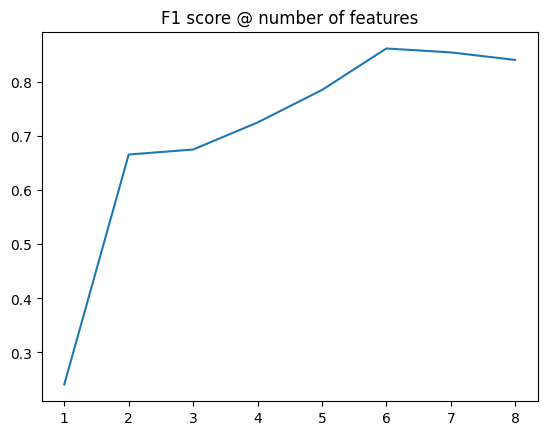

In [15]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient="columns")
plt.plot(range(1,X.shape[1]), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [16]:
pipe = Pipeline([("selector", SelectKBest(chi2, k = 6)), ("classifier",model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["KBest_chi2"] = features.tolist()

<font size = 3><u> 3. KBest univariate feature selection (f_classif test) optimization

In [17]:
# Parameters optimization

pipe = Pipeline([
    ("selector", SelectKBest(f_classif)), ("classifier",model)
])

parameters = {"selector__k": range(1, X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv=cv, scoring="f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'selector__k': 8}
Pipeline(steps=[('selector', SelectKBest(k=8)),
                ('classifier', GradientBoostingClassifier(random_state=1))])


Text(0.5, 1.0, 'F1 score @ number of features')

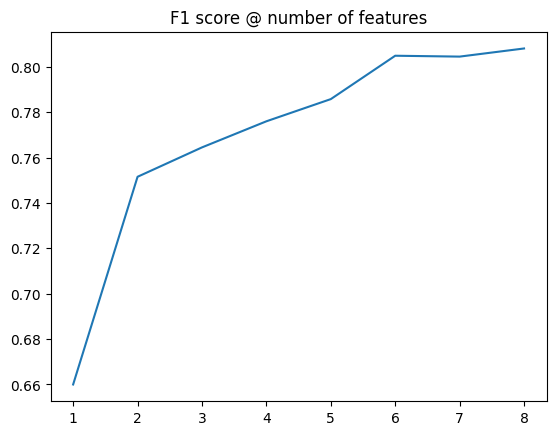

In [18]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient="columns")
plt.plot(range(1,X.shape[1]), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [19]:
pipe = Pipeline([("selector", SelectKBest(f_classif, k = 6)), ("classifier",model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["KBest_ftest"] = features.tolist()

<font size = 3><u> 4. Recursive feature elimination optimization

In [20]:
pipe = Pipeline([("selector", RFE(model, step = 1)),("classifier", model)])

parameters = {"selector__n_features_to_select": range(1, X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv = cv, scoring = "f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'selector__n_features_to_select': 5}
Pipeline(steps=[('selector',
                 RFE(estimator=GradientBoostingClassifier(random_state=1),
                     n_features_to_select=5)),
                ('classifier', GradientBoostingClassifier(random_state=1))])


Text(0.5, 1.0, 'F1 score @ number of features')

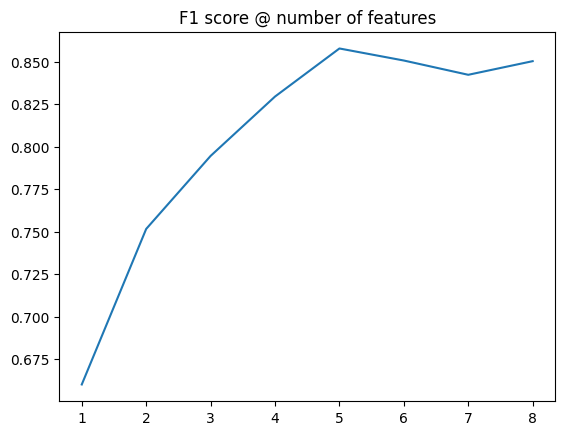

In [21]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient = "columns")
plt.plot(range(1,X.shape[1]), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [22]:
pipe = Pipeline([("selector", RFE(model, n_features_to_select = 5, step = 1)), ("classifier", model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["RFE"] = features.tolist()

<font size = 3><u> 5. Select From Model optimization

In [23]:
pipe = Pipeline([("selector", SelectFromModel(model)), ("classifier", model)])

parameters = {"classifier__max_features": np.arange(1,X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv = cv, scoring = "f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'classifier__max_features': 1}
Pipeline(steps=[('selector',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=1))),
                ('classifier',
                 GradientBoostingClassifier(max_features=1, random_state=1))])


Text(0.5, 1.0, 'F1 score @ number of features')

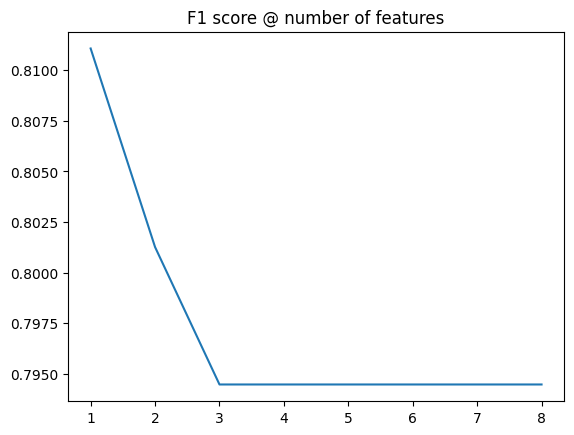

In [24]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient = "columns")
plt.plot(range(1,grid_output.shape[0]+1), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [25]:
model_f1 = GradientBoostingClassifier(max_features = 1)

pipe = Pipeline([("selector", SelectFromModel(model_f1)), ("classifier", model_f1)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()

features = X.columns[mask]

feature_selection["SelectFromModel"] = features.tolist()

<font size = 3><u> 6. Sequential Feature Selector optimization  
\>> forward

In [26]:
pipe = Pipeline([("selector", SequentialFeatureSelector(model, n_features_to_select = "auto", direction = "forward")), ("classifier", model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["forward_select"] = features.tolist()

<font size = 3><u> 6. Sequential Feature Selector optimization  
\>> backward

In [27]:
pipe = Pipeline([("selector", SequentialFeatureSelector(model, n_features_to_select = "auto", direction = "backward")), ("classifier", model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["backward_select"] = features.tolist()

<font size = 3><u> Best subset classification according to F1 score

In [28]:
# Default model

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
model = GradientBoostingClassifier()

pipe = Pipeline([("classifier", model)])

f1_scores = {}
for key in feature_selection.keys():
    columns = feature_selection[key]
    x = X[columns]
    scores = cross_val_score(pipe, x, y, cv=cv, scoring = "f1", n_jobs=-1)
    score = np.mean(scores)
    f1_scores[key] = score

sorted(f1_scores.items(), key = lambda item: item[1], reverse = True)

[('VarianceThreshold', 0.8656267095779764),
 ('KBest_chi2', 0.8645677944839736),
 ('RFE', 0.8575301387145082),
 ('Features_set', 0.8518232067877893),
 ('KBest_ftest', 0.7997819455616706),
 ('SelectFromModel', 0.7925006361007705),
 ('forward_select', 0.7855504972922814),
 ('backward_select', 0.7693976570193096)]

In [29]:
# Model with max_features = 1

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
model = GradientBoostingClassifier(max_features=1)

pipe = Pipeline([("classifier", model)])

f1_scores = {}
for key in feature_selection.keys():
    columns = feature_selection[key]
    x = X[columns]
    scores = cross_val_score(pipe, x, y, cv=cv, scoring = "f1", n_jobs=-1)
    score = np.mean(scores)
    f1_scores[key] = score

sorted(f1_scores.items(), key = lambda item: item[1], reverse = True)

[('KBest_chi2', 0.8491362030855132),
 ('RFE', 0.8402823853261703),
 ('VarianceThreshold', 0.8268514466417886),
 ('Features_set', 0.8119879489123818),
 ('SelectFromModel', 0.7792053365737576),
 ('KBest_ftest', 0.772201003216153),
 ('forward_select', 0.755445336226088),
 ('backward_select', 0.7450805794175797)]

Best F1 score is achieved with Variance Threshold in default model

<b> Model Optimization </b>  
Select appropriate max_depth for VarianceThreshold features 

In [30]:
# Extract feature names - ultimate set

features = feature_selection["VarianceThreshold"]
x = X[features]

In [34]:
# Optimize model with respect to max_depth

model = GradientBoostingClassifier()
pipe = Pipeline([("classifier", model)])

parameters = {"classifier__max_depth": np.arange(1,10,1)}

grid = GridSearchCV(pipe, parameters, cv = cv, scoring = "f1").fit(x,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'classifier__max_depth': 8}
Pipeline(steps=[('classifier', GradientBoostingClassifier(max_depth=8))])


Text(0.5, 1.0, 'F1 score @ number of features')

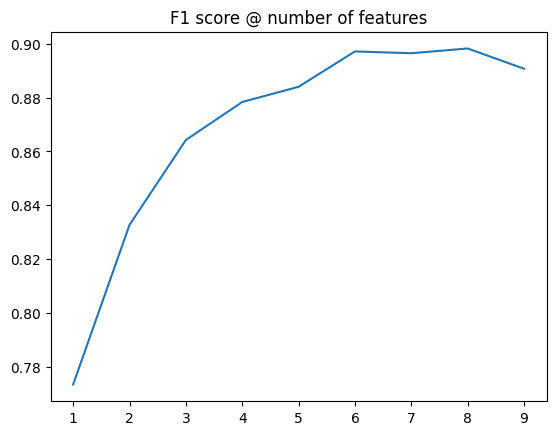

In [35]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient = "columns")
plt.plot(range(1,grid_output.shape[0]+1), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [33]:
# Model with max_depth = 8

<b> Model Diagnostics </b>

In [36]:
# Extract feature names - ultimate set

features = feature_selection["VarianceThreshold"]

In [37]:
# Set X and y variables for logistic regression 

y = df.loc[:,"sell_signal"]
X = df.loc[:, features]

In [39]:
# Fit Decision Tree using subset of variables

model = GradientBoostingClassifier(max_depth = 8)
res = model.fit(X,y)

In [40]:
# Predict using specified model, assuming default threshold of 0.5

predict = res.predict_proba(X)
predict_proba = res.predict_proba(X)[:, 1]
predict_class = [True if x > 0.5 else False for x in predict_proba]

In [41]:
# Model diagnostics on 10-fold stratified data

pipe = Pipeline([("classifier", model)])

ys = []
probabilities = []
classes = []

for train, test in cv.split(X,y):
    X_train, X_test = X.loc[train,:], X.loc[test,:]
    y_train, y_test = y[train], y[test]

    pipe.fit(X_train,y_train)
    probability_test = pipe.predict_proba(X_test)[:,1]
    class_test = [True if x > 0.5 else False for x in probability_test]

    ys += y_test.tolist()
    probabilities += probability_test.tolist()
    classes += class_test

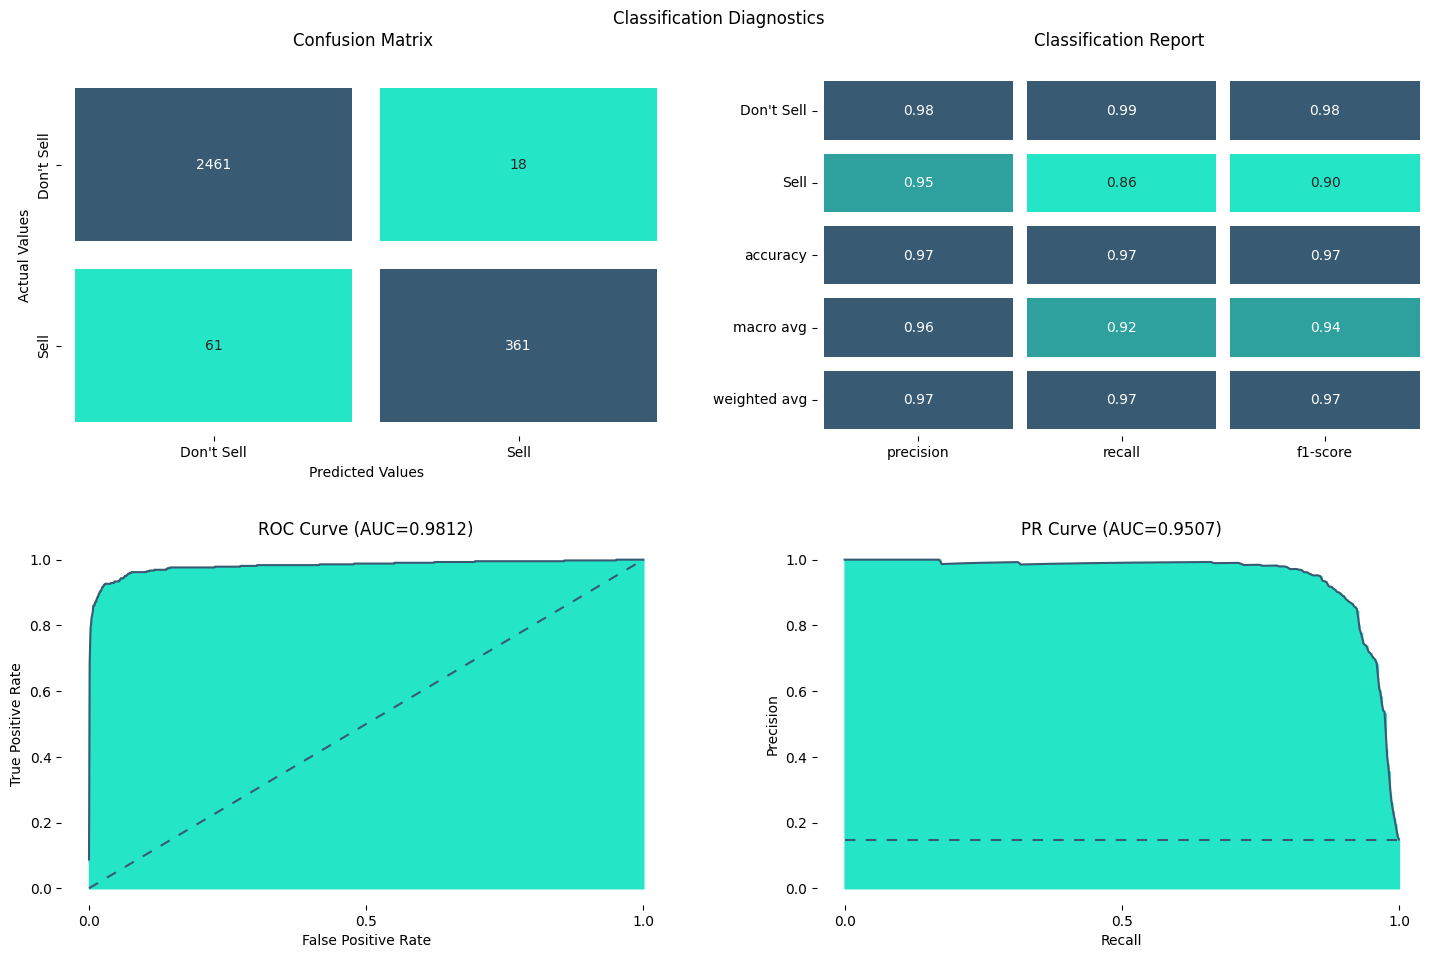

In [42]:
# Perform model CV diagnostics 

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [43]:
# Finding optimal threshold for ROC curve - G-Mean

fpr, tpr, thresholds = roc_curve(ys, probabilities)

gmeans = np.sqrt(tpr * (1 - fpr))
idx = np.argmax(gmeans)
print("Best threshold = %f, G-Mean = %.3f" % (thresholds[idx], gmeans[idx]))

Best threshold = 0.031117, G-Mean = 0.948


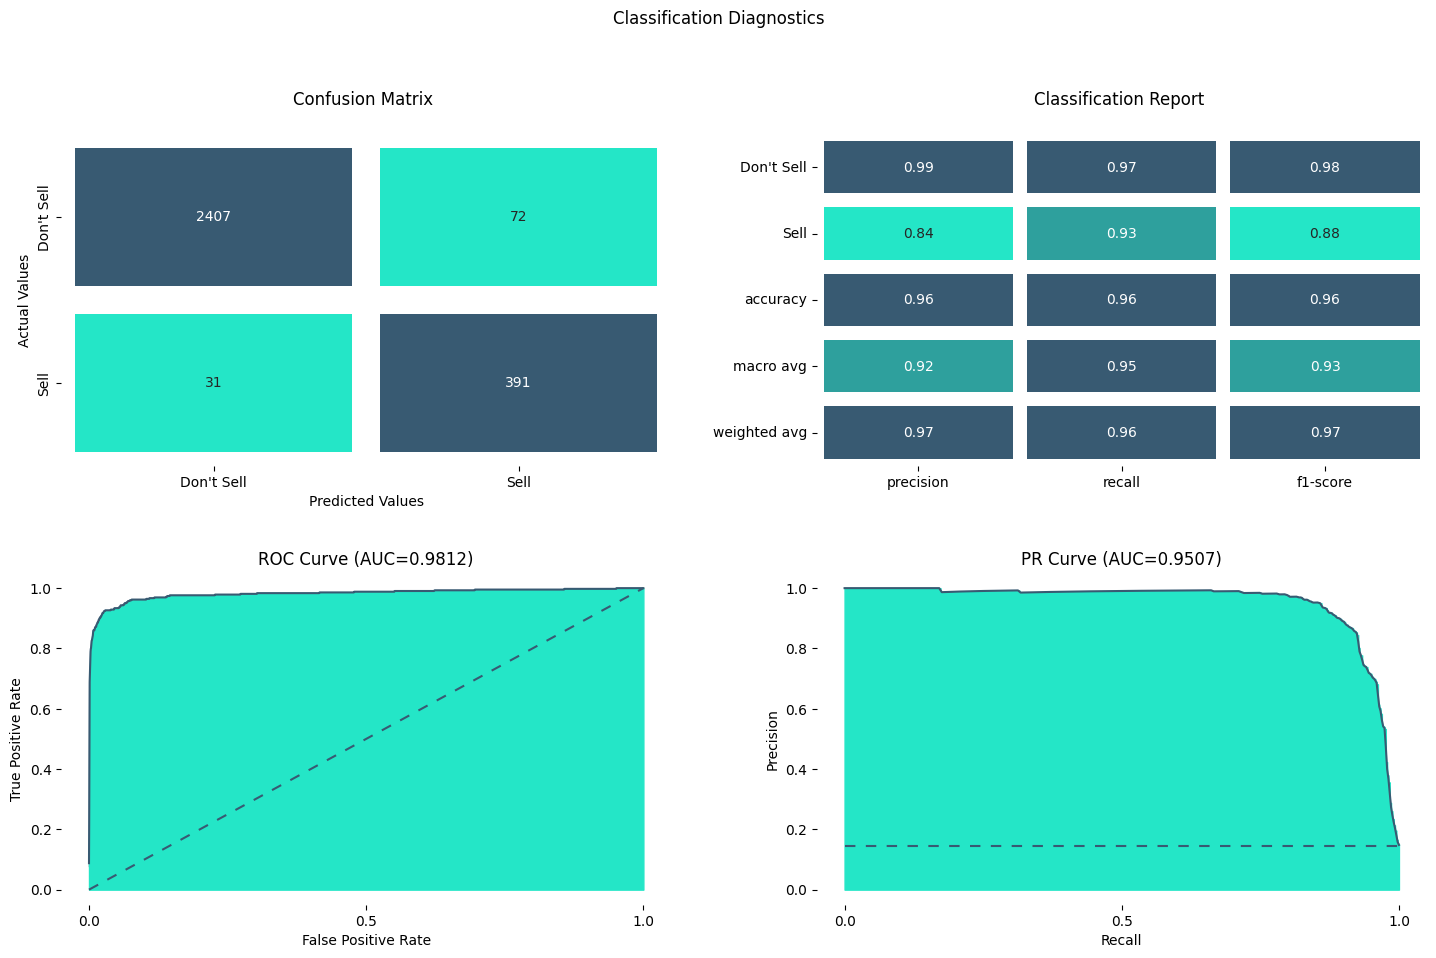

In [44]:
# Threshold of 0.031117 for GMean method, print diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [45]:
# Finding optimal threshold for ROC curve - Youden's J statistic

fpr, tpr, thresholds = roc_curve(ys, probabilities)

J = tpr - fpr
idx = np.argmax(J)
print("Best threshold = %f, J = %.3f" % (thresholds[idx], J[idx]))

Best threshold = 0.031117, J = 0.897


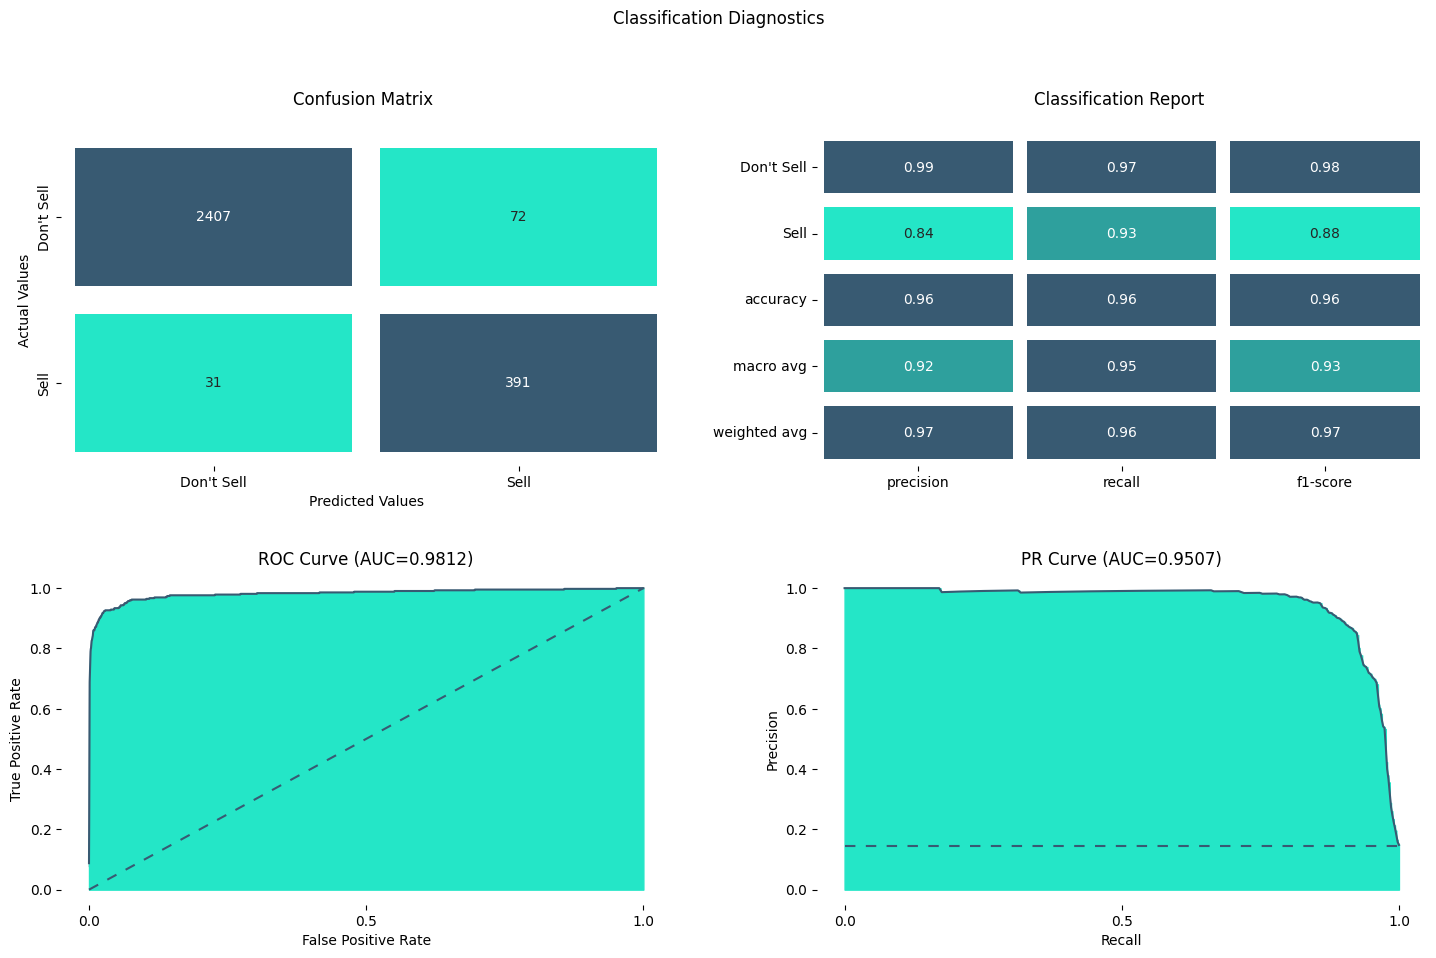

In [46]:
# Threshold of 0.125727 for Youden's J stat, print diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [47]:
# Finding optimal threshold for PR curve - F-Measure

precision, recall, thresholds = precision_recall_curve(ys, probabilities)

fscore = (2 * precision * recall) / (precision + recall)
idx = np.argmax(fscore)
print("Best threshold = %f, F-Score = %.3f" % (thresholds[idx], fscore[idx]))

Best threshold = 0.447046, F-Score = 0.903


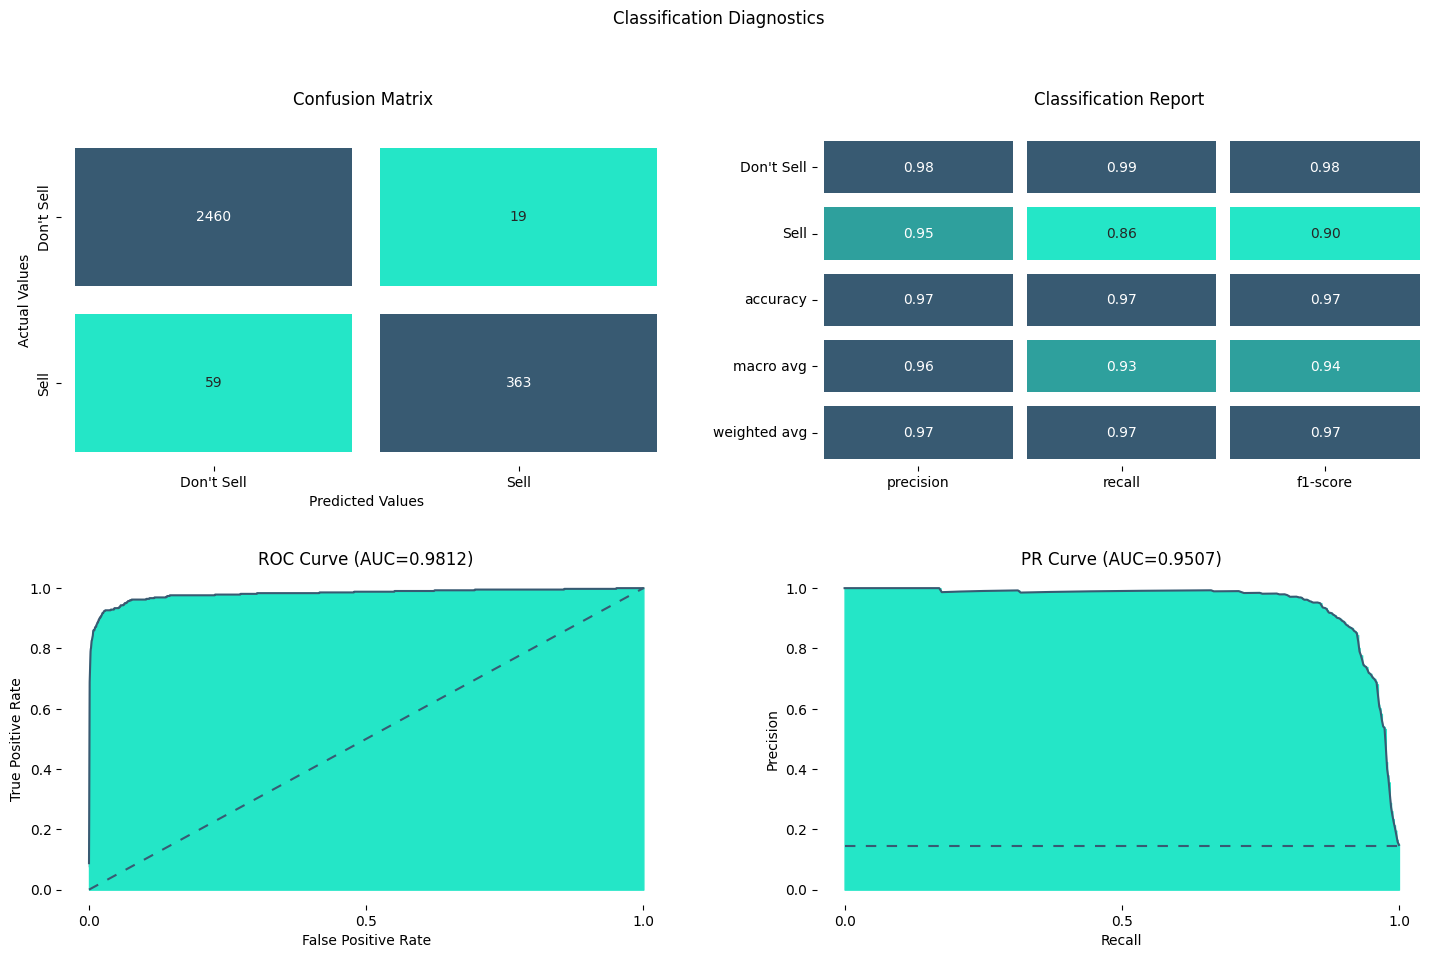

In [48]:
# FMeasure outputs threshold of = 0.447046. For this value, let's reprint diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

<b> WORKINGS